# Machine Learning with Keras - Part 1
## Gabriel Altay
## Binary Classification

In this notebook we review some fundamental theory and a few best practices when designing and implementing machine learning classification models.  We end with a simple linear network for binary classification.

# Import Modules

In [1]:
# set some constants
RAND_SEED_1 = 3826204

import numpy as np
np.random.seed(RAND_SEED_1)

import os
import pandas
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense

Using TensorFlow backend.


In [2]:
import seaborn
import plotters
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

Get the *Iris* dataset included with scikit-learn and load it into a pandas DataFrame.  You can read more about this data set on the wikipedia page [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set).  Below is a short summary,

>The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals [sepal length, sepal width, petal length, petal width], in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

In [3]:
def iris_dataframe(iris):
    """Create DataFrame with Iris data."""                                                              
    df_features = pandas.DataFrame(data=iris.data, columns=iris.feature_names)                      
    df_targets = pandas.DataFrame(data=iris.target, columns=['target_id'])                          
    df_targets['target_name'] = df_targets['target_id'].apply(                                      
        lambda x: iris.target_names[x])                                                             
                                                                                                    
    # could use concat or merge to join the DataFrames                                              
    #df = pandas.concat([df_features, df_targets], axis=1)                                          
    df = pandas.merge(                                                                              
        df_features, df_targets, left_index=True, right_index=True)                                 
    return df 

iris = sklearn.datasets.load_iris()
iris_df = iris_dataframe(iris)
iris_df.head(4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_id,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa


# Some Terminology

Lets setup some terminology so we can refer to things unambiguously.  The *Iris* dataset has measurements of four quantities on 150 different Iris flowers.  The 150 flowers are equaly split among three species.  In the jargon of machine learning, we say that we have 150 samples, four features, and three classes.   

In [4]:
n_features = len(iris.feature_names)
n_samples = len(iris_df)  # number of rows in the DataFrame
n_classes = len(iris.target_names)

print('class names: {}'.format(iris.target_names))
print('feature names: {}'.format(iris.feature_names))
print('n_classes: ', n_classes)
print('n_features: ', n_features)
print('n_samples: ', n_samples)

class names: ['setosa' 'versicolor' 'virginica']
feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
n_classes:  3
n_features:  4
n_samples:  150


# Visualize Raw Data

Because there are four features for each flower in the *Iris* dataset, we can think of this data as living in a 4-D space.  We can visualize the relationship between the four features using the `pairplot` function of the `seaborn` module.  Each point in the off-diagonal panels represents a flower (sample).  The color of each point indicates the class (species) and the position indicates the values for two of the four features.  The six panels in the upper right part of the plot contain the same information as the six panels in the bottom left but the points are reflected through the x=y line.  Together the off-diagonal panels show every possible orthogonal projection of this 4-D data down to a 2-D space.  The diagonal elements show the distribution of values for each individual feature.    

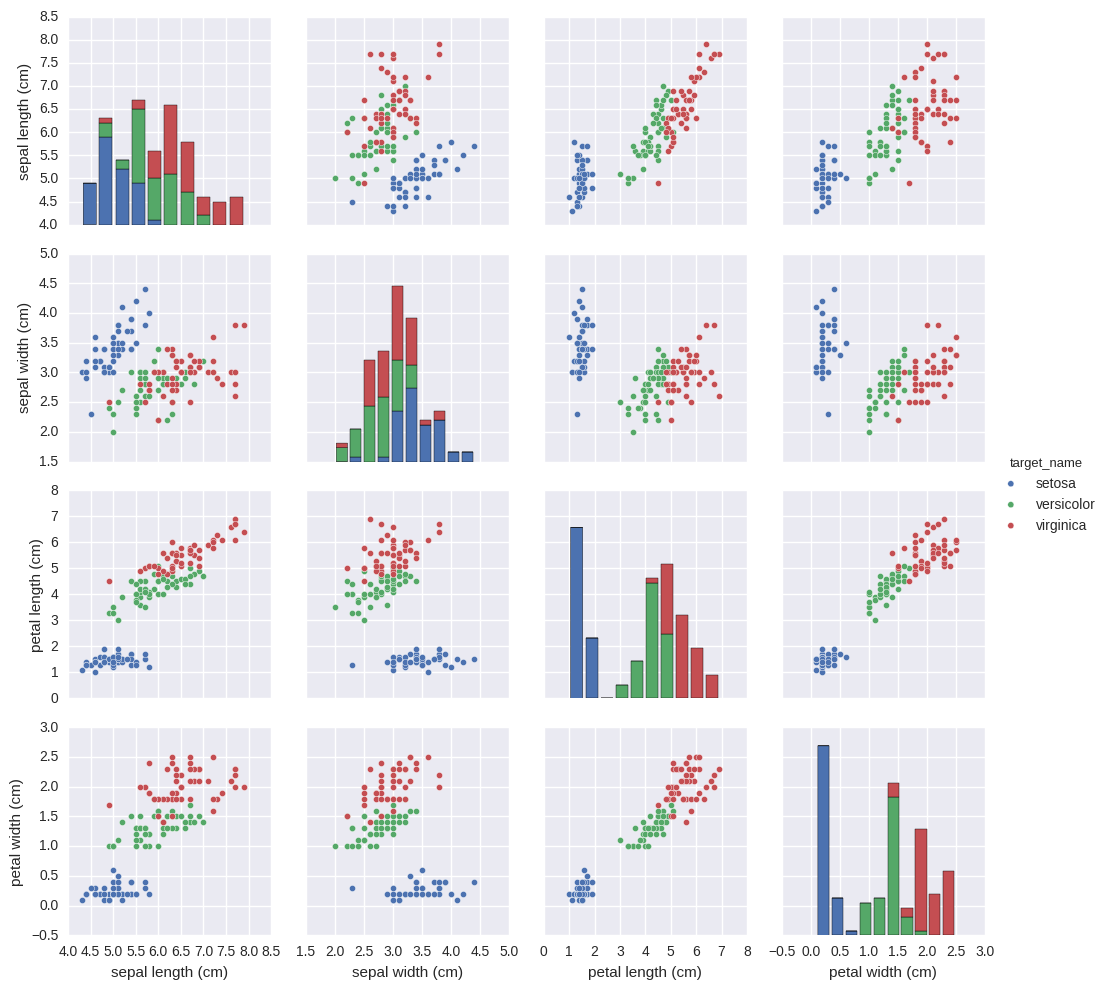

In [5]:
pp = seaborn.pairplot(iris_df, vars=iris.feature_names, hue='target_name')

# Linear Separability

The pairplot above gives us an opportunity to introduce the idea of [linear separability](https://en.wikipedia.org/wiki/Linear_separability).  For the moment, lets forget that the *Iris* data is 4-D and just concentrate on the 2-D plot of petal width vs sepal length in the bottom left panel. Intuitively (in two dimensions), two groups of points are linearly separable if a single line can be drawn that separates them.  For example, we can see that a line defined by petal width = 0.75 will leave all the blue points on one side and all the green and red points on the other.  In this case, we say that the blue points (group 1) are linearly separable from the red and green points (group 2).  On the other hand, there is no line that could be drawn that would separate the red points from the green points.  Therefore, the red and green points are not linearly separable.  

We have confined ourselves to two dimensions so far, but the concept of linear separability can be defined in any number of dimensions (see the technical supplement for more details).  What does this tell us about the 4-D dataset?  While it is true that points that are separable in a projection to lower dimensions (2-D in this case) will also be separable in higher dimensions (i.e. once we add the 3rd and 4th dimension), the argument doesn't run the other way.  While we know the red and green points are not linearly separable in 2-D, we cannot determine if they are linearly separable in 4-D just by looking at the 2-D plots (it turns out they are not linearly separable even in 4-D but we know that only because other people have already worked it out).  In general this has consequences when choosing classification models.  Namely, *all* linear models will be incapable of perfect classification for datasets that are not linearly separable.  This is not necessarily a bad thing (perfect classification of training data can be a sign of overfitting) but it should set our expectations while training models.

# Lets Start with Binary Classification
We can transform the "multi-class" *Iris* classification problem into a binary classification problem by combining the 1=*veriscolor* and 2=*virginica* classes into one class.  This will allow us to start with a very simple problem that we know is linearly separable.  All machine learning texts and code implementations use their own syntax, but there is a set of semi-standard variable names that have been adopted in a wide range of settings.  $X$ is commonly used to represent the "feature matrix" which has one row per sample and one column per feature.  $Y$ is commonly used to refer to the "target vector" or "target array" and stores the true class labels for each sample.  Below we construct these arrays for our toy binary classification problem by keeping class 0 (*setosa*) as is and mapping both class 1 (*veriscolor*) and class 2 (*virginica*) to class 1. 

In [6]:
# Modify data to have only two classes and create variables with standard names                                                       

X = iris_df[iris.feature_names].values  # (n_samples, n_features)                   
Y = iris_df['target_id'].values         # (n_samples,)                              
Y[Y==2] = 1                             # change the 2's to 1's

print('first 5 rows of X')
print(X[0:5, :])
print()

print('All entries in Y')
print(Y)
print()

first 5 rows of X
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]

All entries in Y
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]



# Holding Some Data Back

In order to measure the quality of a model, it is best to test it on data that was not used in the training process.  Doing this allows us to gain insight into the classic problem of under/over fitting (also known as the [bias/variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)).  

In the most basic implementation of this idea, you simply split your data into a training set (for training) and a testing set (for evaluation of model quality).  Typically 15-30% of the data is held back in the test set but there is no magic number that is best.  A more advanced (and computationally more expensive) approach is K-fold cross validation.  In this approach, you first choose a number of K-folds (say k=5) and split your data into k pieces.  Then you train k models.  For each one you use (k-1)/k of the data for training and 1/k of the data for testing (4/5 and 1/5 if k=5).  You can then examine the mean performance of the 5 models to evaluate the quality of the model and you have made use of all of your training data.  For now, we will use a simple 70/30 train test split, but will provide examples of K-fold cross-validation later.  

Another important concept in splitting data is that of "stratification" which is a form a splitting such that the proportion of classes in different data folds or sets is the same as in the whole dataset.  In the case of our modified binary dataset we will maintain the 1/3 = class 1 and 2/3 class = 2 ratio.  Most training methods work best when the classes are balanced (i.e. when we have the same number of each class) however, most training methods allow us to upweight under-represented classes (or equivalently downweight over-represented classes). 

In [7]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y, train_size=0.7, stratify=Y, random_state=RAND_SEED_1) 

# confirm class ratios in Ytrain and Ytest
print('Ytrain.shape: ', Ytrain.shape)
print('Ytest.shape: ', Ytest.shape)
print('Ytrain class 1 / class 0: ', Ytrain.sum() / Ytrain.size)
print('Ytest class 1 / class 0: ', Ytest.sum() / Ytest.size)

Ytrain.shape:  (105,)
Ytest.shape:  (45,)
Ytrain class 1 / class 0:  0.666666666667
Ytest class 1 / class 0:  0.666666666667


# Scaling Data

Many machine learning techniques perform best when the feature data is scaled such that the distribution of values in each feature has a mean of zero and a variance of one.  This is not true for all methods (tree classifiers for example) but it is *almost* never a bad idea.  That being said, extreme outliers can heavily skew scaled data and none of these data preprocessing methods should ever be performed blindly. Scikit learn provides a number of scaling objects that will apply the appropriate transformation on our training data and remember it so that it can also be applied to the test data and future examples we would like to classify.  

In [8]:
scaler = StandardScaler()                                                                           
scaler.fit(Xtrain)                                                                                  
Xtrain_scld = scaler.transform(Xtrain)                                                              
Xtest_scld = scaler.transform(Xtest)   

In [9]:
print('Xtrain_scld.shape: ', Xtrain_scld.shape)
# verify scaled train data has mean=0 for each feature
# reductions on numpy arrays allow us to specify an axis
# 0 = row axis = take mean of each column 
print(Xtrain_scld.mean(axis=0)) 
# verify that the variance is 1
print(Xtrain_scld.var(axis=0))

Xtrain_scld.shape:  (105, 4)
[  1.04519568e-15   1.31217788e-15  -5.31849697e-16  -1.16309079e-17]
[ 1.  1.  1.  1.]


In [10]:
# note that we expect this to be only approximately true for the test 
# data.  the point of the test set is to simulate data that we haven't 
# seen yet.  that is why we only pass Xtrain to the `scaler.fit` method.
# we then transform the test data but using the mean and standard deviation 
# measured from the train data.
print(Xtest_scld.mean(axis=0))
print(Xtest_scld.var(axis=0))

[-0.20513634  0.08374036 -0.05405474  0.05734034]
[ 0.71489486  0.825929    0.89846782  1.06585855]


# Creating a Neural Network Binary Classifier 

The simplest possible neural network we can make to look at our binary *Iris* data has 4 input nodes (one for each feature) and 1 output node.  This architectue is the neural network version of traditional [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).  Note that the activation function we use (`sigmoid`) is simply another name for the `logistic function` $f(x) = 1 / (1 + e^{-x})$.  When using the [sequential model API](https://keras.io/models/sequential/), we instanciate a `Sequantial` object and use its `add` method to add layers.  In this case we add an input layer and a single "Dense" layer which will produce weighted connections to every node in the input layer.  Right after we define the model, we save the weights so we can reset the state of the network when we want.

In [11]:
model_binary = Sequential()
model_binary.add(InputLayer(input_shape=(n_features,)))
model_binary.add(Dense(1, activation='sigmoid'))

weights_initial = model_binary.get_weights()
print('weights_initial - input nodes: \n', weights_initial[0])
print('weights_initial - bias node: ', weights_initial[1])

weights_initial - input nodes: 
 [[ 0.2956866 ]
 [ 0.52667379]
 [-0.23921573]
 [-0.35336095]]
weights_initial - bias node:  [ 0.]


`Keras` models come with a handy method called `summary` that will describe their architecture.  Calling it will show the shape of each layer and the number of parameters that are trainable. 

In [12]:
model_binary.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             5           input_1[0][0]                    
Total params: 5
Trainable params: 5
Non-trainable params: 0
____________________________________________________________________________________________________


The shape of the InputLayer `(None, 4)` indicates that an individual sample has 4 features, but we can pass samples into the network in batches of arbitrary size.  A single sample input would have shape `(1,4)` while batches of 20 samples would have shape `(20,4)`.  Note that the summary method above reported 5 trainable parameters (weights connecting the nodes).  This might seem like more than expected in our fully connected neural network with 4 input nodes connected to 1 output node (4*1=4).  This is because there is also a bias node with a weight associated to it.  I've written a function to visualize the architecture that colors the bias nodes red and draws their weights with dotted lines.  Note that 5 parameters is the same number of parameters we would have in a linear predictor function from logistic regression.  

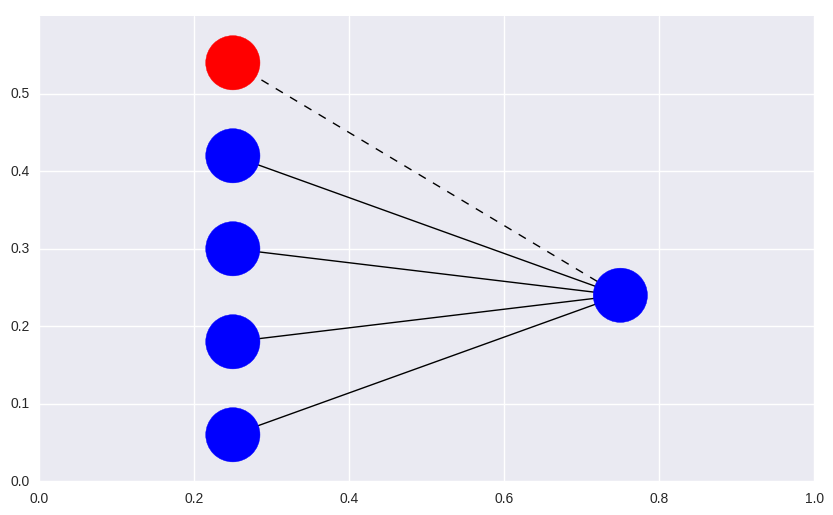

In [13]:
plotters.network_architecture(model_binary)

Now that we have a model architecture in place, we just need to compile it.  During this process we choose an optimizer (a method for minimizing functions), a loss function (the actual function that will be minimized), and a list of metrics to keep track of during training.  The value of the loss function at each iteration of training is stored by default and we add the accuracy to that default list. The accuracy metric is a simple measure of the fraction of samples we classify correctly.  The optimizer we choose (`SGD`) is stochastic gradient descent and the keyword `lr` sets the learning rate.  The loss function, `binary_crossentropy`, is described in more detail in the technical supplement. 

In [14]:
optimizer = keras.optimizers.SGD(lr=1.0e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']
model_binary.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Now we are ready to actually train the model!  There are only two more parameters we have to set.  The `batch_size` determines how many samples are fed through the network before the weights are updated using a stochastic gradient descent step and the `nb_epoch` parameter determines how many times the entire dataset is fed through the network.  For our small dataset it is no problem for us to feed the entire dataset through the network before each weight update.  This gives the most accurate estimate of the gradient we want to descend.  BUT accuracy is not always the best thing.  Using smaller batches is sometimes (maybe most times) better because 1) its faster and 2) it adds noise to the path we take to find a good minimum of the loss function and that allows us to get out of local minima.  

For this example, we will start with a batch size equal to the whole training set and a small learning rate to see what happens. What constitutes a "small" learning rate is almost always empirically determined.  I have selected one for the purposes of this example that we can treat as "small" in the sense that we get improved results later by increasing it.  The model will output to the screen during training and the return value (`mdlout_binary`) will store training and validation losses and accuracies.  After training, we will plot both the loss and accuracy of both the training and test sets for each epoch. 

In [15]:
def plot_acc(history):
    plt.plot(history['acc'], color='red', ls='-', lw=2.0, label='train acc')
    plt.plot(history['loss'], color='red', ls='--', lw=2.0, label='train loss')
    plt.plot(history['val_acc'], color='blue', ls='-', lw=1.0, label='valid acc')
    plt.plot(history['val_loss'], color='blue', ls='--', lw=1.0, label='valid loss')
    plt.legend(ncol=1, bbox_to_anchor=(1.30, 0.8))
    plt.ylim(-0.1, 1.5)

Train on 105 samples, validate on 45 samples
Epoch 1/10
105/105 [==============================] - 0s - loss: 1.0608 - acc: 0.1143 - val_loss: 1.0766 - val_acc: 0.0222
Epoch 2/10
105/105 [==============================] - 0s - loss: 1.0607 - acc: 0.1143 - val_loss: 1.0765 - val_acc: 0.0222
Epoch 3/10
105/105 [==============================] - 0s - loss: 1.0606 - acc: 0.1143 - val_loss: 1.0764 - val_acc: 0.0222
Epoch 4/10
105/105 [==============================] - 0s - loss: 1.0605 - acc: 0.1143 - val_loss: 1.0763 - val_acc: 0.0222
Epoch 5/10
105/105 [==============================] - 0s - loss: 1.0604 - acc: 0.1143 - val_loss: 1.0763 - val_acc: 0.0222
Epoch 6/10
105/105 [==============================] - 0s - loss: 1.0603 - acc: 0.1143 - val_loss: 1.0762 - val_acc: 0.0222
Epoch 7/10
105/105 [==============================] - 0s - loss: 1.0602 - acc: 0.1143 - val_loss: 1.0761 - val_acc: 0.0222
Epoch 8/10
105/105 [==============================] - 0s - loss: 1.0601 - acc: 0.1143 - val_lo

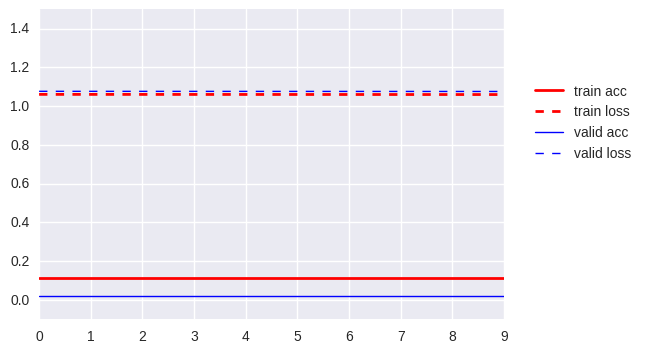

In [16]:
mdlout_binary = model_binary.fit(
    Xtrain_scld, Ytrain, validation_data=(Xtest_scld, Ytest), 
    batch_size=105, nb_epoch=10, verbose=1)
plot_acc(mdlout_binary.history)

Wow!  we produced a really boring plot (I'm guessing ... it's hard to say exactly what will be in the plot as each run will be different due to randomness in the train/test split and the weight initialization of the network).  Having said that, the learning rate, batch size, and number of epochs we chose should not produce much except horizontal lines above.  Lets try resetting the model and training for a lot of epochs.  I turn the verbosity way down this time so we can train for a few thousand epochs without filling up the notebook with logs. 

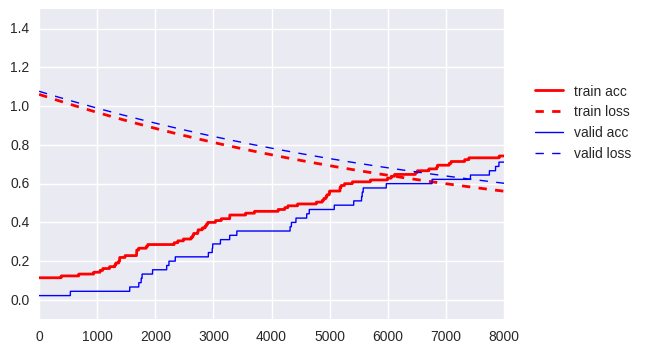

In [17]:
model_binary.set_weights(weights_initial)
mdlout_binary = model_binary.fit(
    Xtrain_scld, Ytrain, validation_data=(Xtest_scld, Ytest), 
    batch_size=105, nb_epoch=8000, verbose=0)
plot_acc(mdlout_binary.history)

That's more like it.  With 8000 epochs of training and 1 weight update per epoch we see the accuracy increasing and the loss function decreasing.  However, we know this problem is linearly separable and so with enough training we know this network should acheive perfect classification.  Lets train for another 8000 epochs and see what happens.  This time we wont reset the weights so the training should be cumulative. 

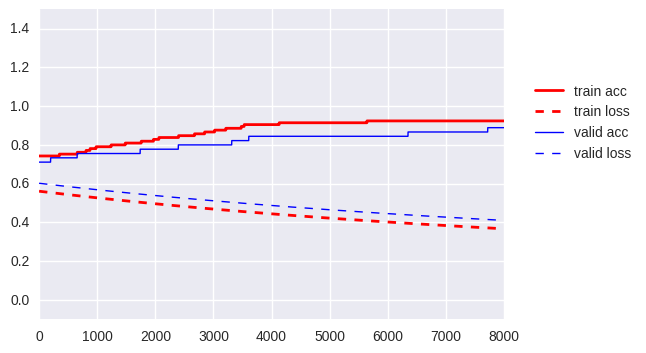

In [18]:
mdlout_binary = model_binary.fit(
    Xtrain_scld, Ytrain, validation_data=(Xtest_scld, Ytest), 
    batch_size=105, nb_epoch=8000, verbose=0)
plot_acc(mdlout_binary.history)

In [19]:
print('final training accuracy: ', mdlout_binary.history['acc'][-1])
print('final test accuracy: ', mdlout_binary.history['val_acc'][-1])

final training accuracy:  0.923809528351
final test accuracy:  0.888888895512


Depending on your luck with the random number generator, the final training and test accuracy should both be close to 1.0 now.  However, this has been a relatively time consuming training adventure for the very small amount of data we have.  Lets see what happens when we update the weights more often by decreasing the batch size.  Just so we can sample the extremes, lets set the batch size to 1 so that we are making a weight update after every sample.  Note that this is approximately a factor of 100 more weight updates per epoch than we were doing before.  

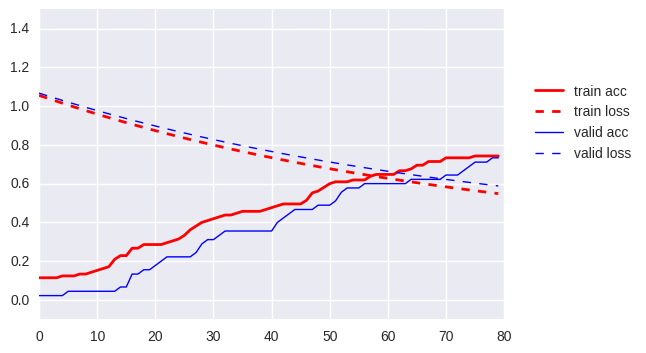

In [20]:
model_binary.set_weights(weights_initial)
mdlout_binary = model_binary.fit(
    Xtrain_scld, Ytrain, validation_data=(Xtest_scld, Ytest), 
    batch_size=1, nb_epoch=80, verbose=0)
plot_acc(mdlout_binary.history)

In [21]:
print('final training accuracy: ', mdlout_binary.history['acc'][-1])
print('final test accuracy: ', mdlout_binary.history['val_acc'][-1])

final training accuracy:  0.742857142857
final test accuracy:  0.733333333333


It looks like setting the batch size to 1 allowed us to train the model much more quickly.  With a training sample size of 105, a batch size of 1, and 80 epochs of training we've made 105 * 80  = 8400 weight updates.  However, we could probably do better by increasing the learning rate.  Lets try that and see what happens. 

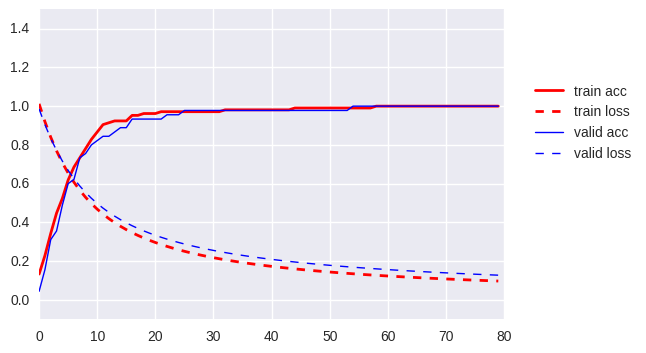

In [22]:
optimizer = keras.optimizers.SGD(lr=1.0e-3)
loss = 'binary_crossentropy'
metrics = ['accuracy']
model_binary.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model_binary.set_weights(weights_initial)
mdlout_binary = model_binary.fit(
    Xtrain_scld, Ytrain, validation_data=(Xtest_scld, Ytest), 
    batch_size=1, nb_epoch=80, verbose=0)

plot_acc(mdlout_binary.history)

In [23]:
print('final training accuracy: ', mdlout_binary.history['acc'][-1])
print('final test accuracy: ', mdlout_binary.history['val_acc'][-1])

final training accuracy:  1.0
final test accuracy:  1.0


And there you have it. With a higher learning rate (0.001) and a batch size of 1 we were able to train the network to have perfect accuracy (note that these particular parameters were set in response to the random numbers produced by the seed we set at the top of the notebook, i.e. they are not universal and your mileage may vary).  We knew from the begininning that this data was linearly separable and so we should not be suprised here.  However, we did get to explore how changing some parameters (learning rate, batch size, number of epochs) changed the efficiency with which we could train the model.  In the next notebook we will get back to the real multi-class *Iris* problem and see how we do. 